# Corpus 전처리

현재 데이터는 xlsx로 저장이 되어 있다. <br/><br/>COCA 코퍼스와 같은 영어 corpus와 비교 예정이기에 전처리가 필요한데, 이를 위해 데이터 저장 포멧은 크게 3가지가 있고 아래와 같다. <br/> <br/> <br/> 1. csv: 엑셀로 읽을 수 있으며 가독성이 좋다. 테이블 형식의 데이터 정리에 유용. <br/> 2. parquet: 하둡과 같은 프레임 워크를 위해 개발된 데이터 압축 형태이고, 압축이 가장 잘되는 열 방향 데이터 정보 포멧. <br/> 3. json: 일반적으로 CS 분야에서 통신이나 테이블 형태가 아닌 데이터 저장에 많이 사용되는 형태. 압축률이 좋지는 않으나 유연한 구조로 인해 확장이 쉽다.<br/><br/> <br/> 고로 이번에는 json으로 사용하려고 한다.

## 개발 환경 세팅

python을 언어로 사용할 거고, uv를 사용해 필요한 라이브러리를 다운로드할 것이다. 
<br/> uv 란? -> python 라이브러리를 굉장히 빨리 다운로드해주는 pkg-manager
<br/> 혹시라도 읽고 계신 분이 CS 분야 전공자라면, 부디 쓰시길 바랍니다. conda, pip 대비 비교도 안될 정도로 빠릅니다,,

만약 github에서 pull하고 사용 중이라면 pyproject.toml 파일을 열어보면 dependencies에서 라이브러리 이름을 확인할 수 있을 텐데 그게 꼭 설치되어야 아래가 진행 가능하다!!!

## 데이터 전처리 전략 및 순서

전처리 순서는 아래와 같다.<br/><br/><br/> 1. 문잔 단위 분할 <br/> 2. 단어 단위 분할 및 품사 태깅

### 문장 기준 분할

수능 영어 듣기 corpus: csat_listening_article

### 라이브러리 import

In [1]:
import nltk # Natural Language Toolkit
import contractions # 영어 줄임말 풀기
import pandas as pd # 데이터 처리
import numpy as np # 데이터 처리
import seaborn as sns # 데이터 시각화
from tqdm import tqdm # 데이터 처리
import re # 정규식으로 특수기호 및 char 처리
import json # 데이터 가공 후 저장할 형식
from typing import Any, Dict, List  # python data-type 정의
from pathlib import Path # 파일 경로 처리
import os # 파일 경로 및 처리

## preprocessor class

In [2]:
class Preprocessor:
    def __init__(self, type:str):
        # corpus 종류에 따라 구분 / 수능 or 교과서
        if type not in ['test', 'textbook']:
            raise ValueError('type must be either "test" or "textbook"')     # 둘 다 아니라면,,
        self.type = type
        
        # nltk에서 제공하는 tokenizer와 tagger를 다운로드: 
        try:
            nltk.download('punkt')  
            nltk.download('punkt_tab')
            nltk.download('averaged_perceptron_tagger_eng')
        except:
            pass
        
    def split_sentences(self, text: str) -> list: # 여러 문장을 각각의 문장으로 분리
        return nltk.sent_tokenize(text)
    
    def tokenize_sentence(self, sentence: str) -> list: # str 형태의 문장은 단어별 품사 태깅(single sentence)
        tokens = nltk.word_tokenize(sentence) # tokenize sentence -> word level
        tagged = nltk.pos_tag(tokens, lang='eng') # tagging the word -> pos(품사) level
        return tagged
    
    def split_word_pos(self, tagged: list) -> list: # 위의 정보를 단어와 품사로 분리
        word_list, pos_list = [], [] # 각각 단어와 품사를 저장할 리스트
        for word, pos in tagged:    # token과 품사 정보를 분리하여 저장.
            word_list.append(word)
            pos_list.append(pos)
        return word_list, pos_list
    
    def change_data_type(self, corpus: pd.DataFrame): # 열 별 데이터 타입 수정.
        
        if self.type == 'test': # 수능 읽기 혹은 듣기 지문
            if '년도' in corpus.columns:    # 수능 읽기, 듣기 지문 파일에만 적용!!
                corpus['년도'] = corpus['년도'].astype('int')
                corpus['월'] = corpus['월'].astype('int')
                corpus['번호'] = corpus['번호'].astype('int')

                corpus = corpus.astype({
                    '년도': 'str',
                    '월': 'str',
                    '번호': 'str',
                    '출처': 'str',
                    '비고': 'str',
                    '본문': 'str'
                })
        elif self.type == 'textbook': # 영어 교과서
            corpus = corpus.astype({
                '출처': 'str',
                '비고': 'str',
                '본문': 'str'})
        

        return corpus
        
    def fillter_values(self, df: pd.DataFrame): # 일부 열 형식 정리
        
        # 숫자만 해당하는 정규식
        number_expression = r'^\d+'

        if self.type == 'test': # 수능 관련 지문들만 처리,,
            if '년도' not in df.columns:    # 해당 파일들은 '년도' column이 있을 테니,,
                raise ValueError('년도 열이 없습니다.')

            for idx, row in tqdm(df.iterrows(), desc='데이터 형식 통일 중..', total=len(df)):
                # NaN, null 값을 채운다.
                if row['본문'] is None: # 혹시라도 본문이 없는 row면 pass
                    continue

                # 모든 정보가 다 있는 경우, 
                if not np.isnan(row['년도']):   # 년도 정보가 없다면 바로 이전 row에서 참고
                    if type(row['년도']) == str:
                        df.loc[idx, '년도'] = re.search(number_expression, row['년도']).group()
                    if type(row['월']) == str:
                        df.loc[idx, '월'] = re.search(number_expression, row['월']).group()
                    if type(row['번호']) == str:
                        df.loc[idx, '번호'] = re.search(number_expression, row['번호']).group()
                    if type(row['출처']) == str:
                        if '수능' in row['출처']:
                            df.loc[idx, '출처'] = '수능'
                        elif '모의' in row['출처']:
                            df.loc[idx, '출처'] = '모의'
                        else:
                            pass
                
                # 일부 정보가 없는 경우
                else:   # 년도 정보가 없다면 바로 이전 row에서 참고
                    df.loc[idx, '년도'] = df.loc[idx-1, '년도']
                    df.loc[idx, '월'] = df.loc[idx-1, '월']
                    df.loc[idx, '출처'] = df.loc[idx-1, '출처']
                    if df.loc[idx, '비고'] is None:
                        df.loc[idx, '비고'] = "."
        
        elif self.type == 'textbook':
            if '저자' not in df.columns:    # 해당 파일들은 '저자' column이 있을 테니,,
                raise ValueError('저자 열이 없습니다.')
            
            remove_row_idxs = []    # 본문이 없는 열들 번호를 저장할 리스트
            sources = [] # 출처 정보를 통합하여 저장할 리스트
            notes = [] # 비고 정보 저장 열
            
            for idx, row in tqdm(df.iterrows(), desc='데이터 형식 통일 중..', total=len(df)):
                
                if row['본문'] is None: # 혹시라도 본문이 없는 row면 collect
                    remove_row_idxs.append(idx)
                
                if row['출판사'] is None:   # 메타 정보 중 일부가 None이라면 str _ 값으로 대체
                    row['출판사'] = '_'
                if row['저자'] is None:
                    row['저자'] = '_'
                if row['과정'] is None:
                    row['과정'] = '_'
                if row['교과서'] is None:
                    row['교과서'] = '_'
                if row['단원'] is None:
                    row['단원'] = '_'
                elif type(row['단원']) != str:
                    row['단원'] = str(row['단원'])
                if row['단원명'] is None:
                    row['단원명'] = '_'
                if row['본문제목'] is None:
                    row['본문제목'] = '_'
                
                source = f"{row['출판사']} {row['저자']} {row['과정']} {row['교과서']}"
                sources.append(source)

                if row['비고'] is None:
                    row['비고'] = '.'
                note = f"{row['단원']} {row['단원명']} {row['본문제목']} / {row['비고']}"
                notes.append(note)
            
            
            # 출처 정보 추가 및 불필요 열 제거
            df['출처'] = sources
            df['비고'] = notes
            df = df.drop(index=remove_row_idxs)
            df = df.drop(columns=['출판사', '저자', '과정', '교과서', '단원', '단원명', '본문제목'])
        
        else:
            raise ValueError('type must be either "test" or "textbook"')
        
        return df

    def generate_json_data(self, id: int, text:str, tokens:list, pos_tags:list, metadata:dict) -> dict:
        """
        주어진 행의 데이터를 JSON 형식으로 변환하는 함수
        
        Args:
            text (str): 원본 텍스트
            tokens (list): 토큰 리스트
            pos_tags (list): 품사 태깅 리스트
            metadata (dict): 메타데이터
        """ 
        
        return {
            "id": id,
            "text": text,
            "tokens": tokens,
            "pos_tags": pos_tags,
            "metadata": metadata
        }

    def get_gender(self, text: str) -> str: # 문장 내에서 화자 성별 탐지
        if 'M:' in text or 'M ' in text:
            return 'M'
        elif 'W:' in text or 'W ' in text:
            return 'W'
        else:
            return 'N'


In [3]:
# sample
preprocessor = Preprocessor()
text = "I am a student. I am a professor."

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bagjuhyeon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/bagjuhyeon/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/bagjuhyeon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [4]:
# example
sentences = preprocessor.split_sentences(text)
for sentence in sentences:
    #print(preprocessor.tokenize_sentence(sentence))
    print(preprocessor.split_word_pos(preprocessor.tokenize_sentence(sentence)))

(['I', 'am', 'a', 'student', '.'], ['PRP', 'VBP', 'DT', 'NN', '.'])
(['I', 'am', 'a', 'professor', '.'], ['PRP', 'VBP', 'DT', 'NN', '.'])


예상하는 json 데이터 구조
<br>
~~~json
{
  "text": "원본 텍스트",
  "tokens": ["토큰1", "토큰2"],
  "pos_tags": ["NN", "VB"],
  "metadata": {
    "source": "수능",
    "year": "2023",
    "month": "6",
    "note": ".",
    "gender": "M",
    "type": "listening"
  }
}
~~~

## 수능 Corpus 전처리

In [5]:
# 영어 듣기 지문 읽어오기
listening_article = pd.read_excel('csat_listening_article.xlsx')
listening_article

,년도,월,번호,출처,본문,비고
0,2016.0,11,1.0,수능,"W: Charlie, where did you get these apples? Th...",.
1,NaN,NaN,2.0,NaN,M: Excuse me. I see the 2 o’clock flight to Da...,.
2,NaN,NaN,3.0,NaN,"W: Hello, listeners! This is One Minute Health...",.
3,NaN,NaN,4.0,NaN,"M: Ms. Robinson, what was your opinion of Mr. ...",.
4,NaN,NaN,5.0,NaN,"W: How was everything, Mr. Silverman? \nM: Goo...",.
...,...,...,...,...,...,...
1302,NaN,NaN,13.0,NaN,① W: What can I do for you today?\nM: I'd like...,그림의 상황에 적절한 대화를 고르는 문제 / 답 4
1303,NaN,NaN,14.0,NaN,W: You must be my new next door neighbor. Welc...,NaN
1304,NaN,NaN,15.0,NaN,"W: Hey, Joe. How are you doing?\nM: Hi, Michel...",NaN
1305,NaN,NaN,16.0,NaN,"W: Peter, how's the planning for the school fe...",NaN


In [6]:
# 전체 행은 1307, 본문이 있는 행은 1234 -> 본문이 있는 행만 기준으로 처리
listening_article.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1307 entries, 0 to 1306
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   년도      77 non-null     float64
 1   월       77 non-null     object 
 2   번호      1306 non-null   float64
 3   출처      77 non-null     object 
 4   본문      1234 non-null   object 
 5   비고      1291 non-null   object 
dtypes: float64(2), object(4)
memory usage: 61.4+ KB


In [7]:
# 결측치 제거 후 불필요 행 지우기
listening_article = preprocessor.fillter_values(listening_article).dropna(how='any')

NaN 값 채우기: 100%|██████████| 1307/1307 [00:00<00:00, 3164.73it/s]


In [8]:
listening_article.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1218 entries, 0 to 1302
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   년도      1218 non-null   float64
 1   월       1218 non-null   object 
 2   번호      1218 non-null   float64
 3   출처      1218 non-null   object 
 4   본문      1218 non-null   object 
 5   비고      1218 non-null   object 
dtypes: float64(2), object(4)
memory usage: 66.6+ KB


In [9]:
listening_article = preprocessor.change_data_type(listening_article)

/var/folders/3t/7cyq0j713bn7qcyfypl8dx3w0000gn/T/ipykernel_1802/2391515850.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['년도'] = corpus['년도'].astype('int')
/var/folders/3t/7cyq0j713bn7qcyfypl8dx3w0000gn/T/ipykernel_1802/2391515850.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['월'] = corpus['월'].astype('int')
/var/folders/3t/7cyq0j713bn7qcyfypl8dx3w0000gn/T/ipykernel_1802/2391515850.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [10]:
listening_article.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1218 entries, 0 to 1302
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   년도      1218 non-null   object
 1   월       1218 non-null   object
 2   번호      1218 non-null   object
 3   출처      1218 non-null   object
 4   본문      1218 non-null   object
 5   비고      1218 non-null   object
dtypes: object(6)
memory usage: 66.6+ KB


In [11]:
print(listening_article['출처'].unique())
print(listening_article['년도'].unique())
print(listening_article['월'].unique())
print(listening_article['번호'].unique())
print(listening_article['비고'].unique())

['수능' '모의']
['2016' '2017' '2018' '2019' '2020' '2021' '2022' '2023' '2024' '2015'
 '2025' '2014' '2013' '2012' '2011' '2010' '2009' '2008' '2007' '2006'
 '2005' '2004' '2003' '2002' '2001' '2000' '1999']
['11' '12' '6' '9']
['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21']
['.' '그림의 상황에 적절한 대화를 고르는 문제 / 답 4' '그림의 상황에 적절한 대화를 고르는 문제 / 답 3'
 '그림의 상황에 적절한 대화를 고르는 문제 / 답 5' '그림의 상황에 적절한 대화를 고르는 문제 / 답 1'
 '그림의 상황에 적절한 대화를 고르는 문제 / 답 2' 'A5' 'A7' 'A16' 'A17' 'A19' 'A20']


병렬 처리 참고: https://yganalyst.github.io/data_handling/memo_17_parallel/


In [4]:
class JsonFileHandler:
    """
    JSON 파일 처리를 담당하는 클래스
    """
    def __init__(self):
        pass
        
    def update_json_file(self, file_path: str, new_data: Any) -> None:
        """
        JSON 파일을 읽고 데이터를 추가한 후 다시 저장
        - 리스트인 경우: id가 동일한 객체가 있으면 덮어씁니다.
        - 리스트가 아닌 경우: id가 다른 객체면 리스트로 변환하여 저장합니다.
        
        Args:
            file_path (str): JSON 파일 경로
            new_data (Any): 추가할 데이터 (id 필드가 있어야 함)
        """
        try:
            # new_data가 딕셔너리이고 id 필드를 포함하는지 확인
            if not isinstance(new_data, dict) or 'id' not in new_data:
                raise ValueError("new_data는 'id' 필드를 포함하는 딕셔너리여야 합니다.")
            
            # 파일 경로 객체 생성
            file_path_obj = Path(file_path)
            
            # 디렉토리가 존재하지 않으면 생성
            file_path_obj.parent.mkdir(parents=True, exist_ok=True)

            # 파일이 존재하는 경우 기존 데이터 읽기
            if Path(file_path).exists():
                with open(file_path, 'r', encoding='utf-8') as f:
                    existing_data = json.load(f)
            else:
                existing_data = []
            
            # 데이터 추가
            if isinstance(existing_data, list):
                # id가 동일한 객체 찾기
                found = False
                for i, item in enumerate(existing_data):
                    if isinstance(item, dict) and item.get('id') == new_data['id']:
                        existing_data[i] = new_data  # 기존 데이터 덮어쓰기
                        found = True
                        break
                
                # id가 동일한 객체가 없으면 새로 추가
                if not found:
                    existing_data.append(new_data)
                    
            elif isinstance(existing_data, dict):
                # 기존 데이터가 딕셔너리이고 id가 다른 경우
                if existing_data.get('id') != new_data['id']:
                    # 기존 데이터와 새로운 데이터를 리스트로 변환
                    existing_data = [existing_data, new_data]
                else:
                    # id가 같은 경우 덮어쓰기
                    existing_data = new_data
            else:
                # 기존 데이터가 리스트나 딕셔너리가 아닌 경우
                # 새로운 데이터를 리스트로 변환하여 저장
                existing_data = [new_data]
            
            # 데이터 저장
            with open(file_path, 'w', encoding='utf-8') as f:
                json.dump(existing_data, f, ensure_ascii=False, indent=2)
                
        except json.JSONDecodeError:
            print(f"JSON 파일 형식이 올바르지 않습니다: {file_path}")
        except Exception as e:
            print(f"오류 발생: {str(e)}")
    
    def load_data(self, file_path: str) -> Any:
        """
        JSON 파일에서 데이터 로드
        
        Returns:
            Any: 로드된 데이터
        """
        try:
            if Path(file_path).exists():
                with open(file_path, 'r', encoding='utf-8') as f:
                    return json.load(f)
            return None
        except Exception as e:
            print(f"데이터 로드 중 오류 발생: {str(e)}")
            return None

In [9]:
def preprocess_article(corpus: pd.DataFrame, corpus_type: str, preprocessor: Preprocessor, json_handler: JsonFileHandler):
    
    if 'test' in corpus_type: # 수능 corpus
        for idx, row in tqdm(corpus.iterrows(), desc='separating sentences..', total=len(corpus)):
            sentences = preprocessor.split_sentences(row['본문'])
            
            before_gender = 'N' # 초기 화자의 성별 초기화
            for sentence in sentences:  # 문장 더미에서 하나의 문장을 가져와서
                
                current_gender = preprocessor.get_gender(sentence)   # 문장 내 화자 성별 정보 추출
                if current_gender == 'N':   # 만약 문장 내에서 확인이 되지 않는다면,
                    current_gender = before_gender # 이전 화자의 성별 유지
                else:   # 문장 내에세 화자 성별이 포착되었다면,
                    before_gender = current_gender # 다음 문장을 위해 성별 정보 업데이트
                
                if current_gender != 'N':
                    sentence = sentence.replace(current_gender+':', '') # 원 문장에서 성별 정보 제거
                    sentence = sentence.replace(current_gender+' ', '') # 원 문장에서 성별 정보 제거

                cleaned_sentence = sentence.lower()
                cleaned_sentence = contractions.fix(cleaned_sentence)
                cleaned_sentence = re.sub(r'[^a-zA-Z0-9,.!?%]', ' ', cleaned_sentence) # 여러 spacebar가 포함되지만, tokenize에서 정리됨. 영어, 숫자, 콤마, 온점, 퍼센트만 유지
                
                tokenized = preprocessor.tokenize_sentence(cleaned_sentence) # 문장 -> 어절 분리
                word_list, pos_list = preprocessor.split_word_pos(tokenized) # 어절 -> 단어 및 품사 분리

                metadata = {
                    "source": row['출처'],
                    "year": row['년도'],
                    "month": row['월'],
                    "note": row['비고'],
                    "gender": current_gender,
                    "type": corpus_type
                }
                
                json_data = preprocessor.generate_json_data(id = idx, text=sentence, tokens=word_list, pos_tags=pos_list, metadata=metadata)
                json_file_name = f"{corpus_type}_article_{row['년도']}_{row['출처']}.json"
                json_file_path = os.path.join(Path.cwd(), 'corpus', json_file_name)
                json_handler.update_json_file(json_file_path, json_data)
    
    elif 'textbook' in corpus_type:
        for idx, row in tqdm(corpus.iterrows(), desc='separating sentences..', total=len(corpus)):
            sentences = preprocessor.split_sentences(row['본문'])

            for sentence in sentences:  # 문장 더미에서 하나의 문장을 가져와서
                cleaned_sentence = sentence.lower()
                cleaned_sentence = contractions.fix(cleaned_sentence)
                cleaned_sentence = re.sub(r'[^a-zA-Z0-9,.!?%]', ' ', cleaned_sentence) # 여러 spacebar가 포함되지만, tokenize에서 정리됨. 영어, 숫자, 콤마, 온점, 퍼센트만 유지
                
                tokenized = preprocessor.tokenize_sentence(cleaned_sentence) # 문장 -> 어절 분리
                word_list, pos_list = preprocessor.split_word_pos(tokenized) # 어절 -> 단어 및 품사 분리

                metadata = {
                    "source": row['출처'],
                    "note": row['비고'],
                    "type": corpus_type
                }
                
                json_data = preprocessor.generate_json_data(id = idx, text=sentence, tokens=word_list, pos_tags=pos_list, metadata=metadata)
                json_file_name = f"{corpus_type}_article_{row['출처']}.json"
                json_file_path = os.path.join(Path.cwd(), 'corpus', json_file_name)
                json_handler.update_json_file(json_file_path, json_data)


### 바로 실행,,

In [14]:
preprocessor = Preprocessor(type='test')
json_handler = JsonFileHandler()

# 영어 듣기 지문 읽어오기
listening_article = pd.read_excel('csat_listening_article.xlsx')
listening_article = preprocessor.fillter_values(listening_article).dropna(how='any')
listening_article = preprocessor.change_data_type(listening_article)
preprocess_article(corpus=listening_article, corpus_type='test_listening', preprocessor=preprocessor, json_handler=json_handler)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bagjuhyeon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/bagjuhyeon/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/bagjuhyeon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
separating sentences..: 100%|██████████| 1218/1218 [00:11<00:00, 102.34it/s]


### 읽기 지문도 동일하게 처리

In [15]:
# 영어 듣기 지문 읽어오기
reading_article = pd.read_excel('csat_reading_article.xlsx')
reading_article = preprocessor.fillter_values(reading_article).dropna(how='any')
reading_article = preprocessor.change_data_type(reading_article)
preprocess_article(corpus=reading_article, corpus_type='test_reading', preprocessor=preprocessor, json_handler=json_handler)

separating sentences..: 100%|██████████| 2168/2168 [00:18<00:00, 117.16it/s]


## 영어 교과서 Corpus 전처리

예상하는 json 데이터 구조
<br>
~~~json
{
  "text": "원본 텍스트",
  "tokens": ["토큰1", "토큰2"],
  "pos_tags": ["NN", "VB"],
  "metadata": {
    "source": "수능",
    "year": "2023",
    "month": "6",
    "note": ".",
    "gender": "M",
    "type": "listening"
  }
}
~~~

In [10]:
textbook_article = pd.read_excel('english_textbook_article.xlsx')
textbook_article.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698 entries, 0 to 697
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   출판사     698 non-null    object
 1   저자      698 non-null    object
 2   과정      698 non-null    object
 3   교과서     698 non-null    object
 4   단원      698 non-null    object
 5   단원명     695 non-null    object
 6   본문제목    643 non-null    object
 7   본문      620 non-null    object
 8   비고      698 non-null    object
dtypes: object(9)
memory usage: 49.2+ KB


In [11]:
preprocessor = Preprocessor(type='textbook')
json_handler = JsonFileHandler()
textbook_article = preprocessor.fillter_values(textbook_article).dropna(how='any')
textbook_article = preprocessor.change_data_type(textbook_article)
preprocess_article(corpus=textbook_article, corpus_type='textbook', preprocessor=preprocessor, json_handler=json_handler)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bagjuhyeon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/bagjuhyeon/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/bagjuhyeon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
separating sentences..: 100%|██████████| 620/620 [00:14<00:00, 43.45it/s] 


# Corpus 분석

## 수능 및 모의고사 지문 분석

In [12]:
import seaborn as sns

In [13]:
corpus_path = os.path.join(Path.cwd(), 'corpus')
corpus_list = os.listdir(corpus_path)
corpus_list = [file for file in corpus_list if file.endswith('.json')]
reading_corpus_list = [file for file in corpus_list if 'reading' in file]
listening_corpus_list = [file for file in corpus_list if 'listening' in file]
textbook_corpus_list = [file for file in corpus_list if 'textbook' in file]
reading_corpus_list
listening_corpus_list
textbook_corpus_list
# 데이터 로드
reading_corpus = json_handler.load_data(os.path.join(corpus_path, reading_corpus_list[0]))
listening_corpus = json_handler.load_data(os.path.join(corpus_path, listening_corpus_list[0]))
textbook_corpus = json_handler.load_data(os.path.join(corpus_path, textbook_corpus_list[0]))

<Axes: xlabel='count'>

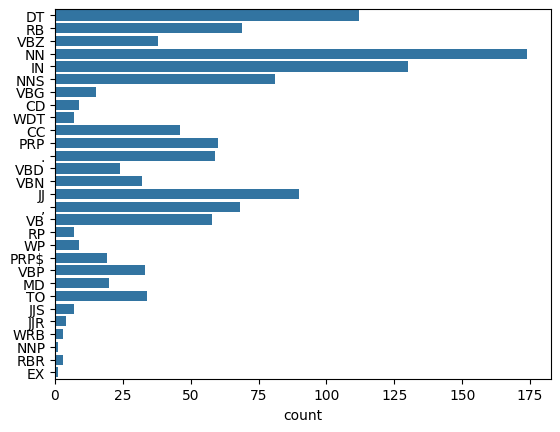

In [14]:
# 읽기 지문 품사 분석
pos_list = []
for article in reading_corpus:
    pos_list.extend(article['pos_tags'])

len(pos_list)
sns.countplot(pd.Series(pos_list))

<Axes: xlabel='count'>

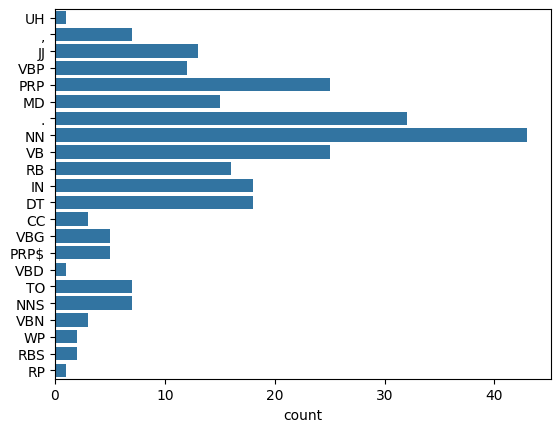

In [15]:
# 듣기 지문 품사 분석
pos_list = []
for article in listening_corpus:
    pos_list.extend(article['pos_tags'])

len(pos_list)
sns.countplot(pd.Series(pos_list))

<Axes: xlabel='count'>

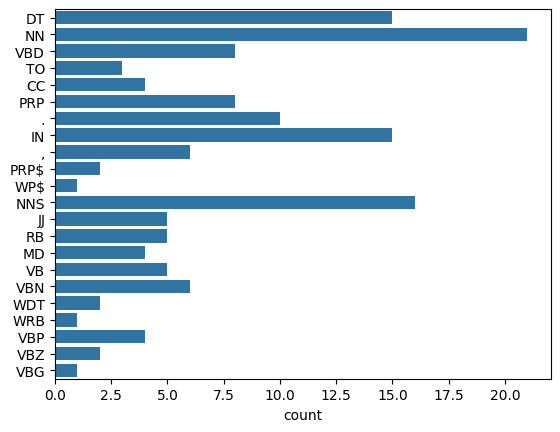

In [16]:
# 듣기 지문 품사 분석
pos_list = []
for article in textbook_corpus:
    pos_list.extend(article['pos_tags'])

len(pos_list)
sns.countplot(pd.Series(pos_list))

In [1]:
import contractions
import nltk
from nltk.tokenize import word_tokenize

In [8]:
expanded_text = contractions.fix("I'm running for 2 hours.")
expanded_text


'I am running for 2 hours.'

In [9]:
tokens = word_tokenize(expanded_text)
tokens



['I', 'am', 'running', 'for', '2', 'hours', '.']

In [10]:
nltk.pos_tag(tokens)

[('I', 'PRP'),
 ('am', 'VBP'),
 ('running', 'VBG'),
 ('for', 'IN'),
 ('2', 'CD'),
 ('hours', 'NNS'),
 ('.', '.')]

### **어간 추출(Stemming) 및 표제어 추출(Lemmatization)**
- 두 기법 모두 자연어 처리에서 텍스트 전처리 과정 중에 단어의 원형을 찾는 데 사용.

- 일반적으로 표제어 추출은 어간 추출보다 정교하고 문맥을 잘 이해하는 방식이기 때문에, 자연어 처리에서 더 많이 사용.<br><br>

- **어간 추출** : 단순한 접미사 제거 방식으로 단어의 어간을 추출. 결과는 사전에 있는 단어가 아닐 수 있다.

- **표제어 추출** : 문법적, 의미적으로 올바른 표준 형태의 단어를 추출. 결과는 사전에 등재된 실제 단어.<br><br>

1. **어간 추출 (Stemming)** : 

    - 어간 추출은 단어의 어간(stem)만 남기고 접사(suffix)를 제거하여 단어의 기본 형태를 찾는 과정.

    - 예를 들어, "running", "runs", "runner"는 모두 "run"이라는 어간을 가지고 있다. 따라서 어간 추출은 이들을 모두 "run"으로 축소.

    - 어간 추출은 단순히 규칙 기반의 접미사 제거 방식이기 때문에, 결과로 나오는 단어는 실제 사전에 있는 단어일 필요는 없고, 때로는 일반적이지 않은 형태일 수 있다.<br><br>


2. **표제어 추출 (Lemmatization)** :

    - 표제어 추출은 단어의 표준 형태인 표제어(lemma)를 찾는 과정입니다.

    - 표제어는 사전에 등재된 실제 단어. 예를 들어, "running"의 표제어는 "run", "better"의 표제어는 "good"입니다.

    - 표제어 추출은 단어의 문맥을 고려하고, 형태소 분석(morphological analysis)을 수행하여 단어의 형태와 문법적 의미를 이해한 후에 추출.

    - 따라서 표제어 추출은 언어적, 문법적 규칙을 적용하여 단어를 정규화하는 과정.

### **고민해 봐야할 점**
- **위 두 과정이 필요한가?**

    - 일단 비교 대상이 COCA라면, COCA랑 뭘 비교할 수 있을지 생각해보자.

    - 현재 전처리에서는 동사의 품사 변형 형들에 대한 고려가 되어 있지 않음.
        - e.g. 'running' -> 'VBG' not a 'Verb'
        - 이를 lemmatation 해야할까? 아니면, wordPiece 사용해서 'preprocessing' -> 'pre#' + 'process' + '#ing' 처럼 처리해서 동사별 비교 때 동사의 범위로 봐야할까?
        
    - 축약형들에 대한 조금 더 나은 처리 방법
        - e.g. 'I'm' -> 'I am'으로 잘 되지만, 'Car's' -> 'car s'로 분리된다. 모호하거나 "'s" 에 대한 처리가 조금 더 필요할 듯,,
    